In [6]:
!pip install agate

In [65]:
#Draw the chart between perceived corruption scoeres compared to the child labour percentages using matplotlib
import xlrd
from xlrd.sheet import ctype_text
import agate
import numpy
import json
import matplotlib.pyplot as plt

#declare the types of data in the dataset
text_type=agate.Text()
number_type=agate.Number()
boolean_type=agate.Boolean()
date_type=agate.Date()

#define a function to get the types of the data
def get_types(example_row):
    types=[]
    for v in example_row:
        value_type=ctype_text[v.ctype]
        if value_type=='text':
            types.append(text_type)
        elif value_type=='number':
            types.append(number_type)
        elif value_type=='boolean':
            types.append(boolean_type)
        elif value_type=='xldate':
            types.append(date_type)
        else:
            types.append(text_type)
    return types

#define a fucntion to create a table 
def get_table(new_arr,types,titles):
    try:
     table=agate.Table(new_arr,titles,types)
     return table
    except Exception as e:
        print(e)
cpi_workbook=xlrd.open_workbook('corruption_perception_index.xls')
cpi_sheet=cpi_workbook.sheets()[0]


cpi_title_rows=zip(cpi_sheet.row_values(1),cpi_sheet.row_values(2))  #zip fuction is combine multiple in to single list

cpi_titles=[t[0]+''+t[1] for t in cpi_title_rows]
cpi_titles=[t.strip() for t in cpi_titles]

cpi_rows=[cpi_sheet.row_values(r) for r in range(3,cpi_sheet.nrows)]
cpi_types=get_types(cpi_sheet.row(3))
cpi_table=get_table(cpi_rows,cpi_types,cpi_titles)

try:
    workbook=xlrd.open_workbook('unicef_oct_2014.xls')
    sheet=workbook.sheets()[0]

except Exception as e:
    print(e)
    
title_rows=list(zip(sheet.row_values(4),sheet.row_values(5)))
titles=[t[0]+''+t[1] for t in title_rows]
titles=[t.strip() for t in titles]
country_rows=[sheet.row_values(r) for r in range(6,114)]


example_row=sheet.row(6)
types=[]
types=get_types(example_row)

#Define a function to remove the bad characters from the data
def remove_bad_chars(val):
    if val=='-':
        return None
    return val

cleaned_rows=[]

def get_new_array(old_array,function_to_clean):
    new_arr=[]
    for row in old_array:
        cleaned_row=[function_to_clean(rv) for rv in row]
        new_arr.append(cleaned_row)
    return new_arr
cleaned_rows=get_new_array(country_rows,remove_bad_chars)
table=agate.Table(cleaned_rows,titles,types)
ranked=table.compute([('total child labour rank' , agate.Rank('Total (%)',reverse=True)),])

cpi_and_cl=cpi_table.join(ranked,'Country / Territory','Countries and areas',inner=True)
print(cpi_and_cl.column_names)


('Country Rank', 'Country / Territory', 'WB Code', 'IFS Code', 'Region', 'Country Rank_2', 'CPI 2013 Score', 'Surveys Used', 'Standard Error', '90% Confidence intervalLower', 'Upper', 'Scores rangeMIN', 'MAX', 'Data sourcesAFDB', 'BF (SGI)', 'BF (BTI)', 'IMD', 'ICRG', 'WB', 'WEF', 'WJP', 'EIU', 'GI', 'PERC', 'TI', 'FH', 'Total (%)', 'c', 'Sex (%)Male', 'Female', 'Place of residence (%)Urban', 'Rural', 'Household wealth quintile (%)Poorest', 'Second', 'Middle', 'Fourth', 'Richest', 'Reference Year', 'Data Source', 'total child labour rank')


C:\Users\cmrit\anaconda3\Lib\site-packages\agate\utils.py:290: DuplicateColumnWarning: Column name "Country Rank" already exists in Table. Column will be renamed to "Country Rank_2".
C:\Users\cmrit\anaconda3\Lib\site-packages\agate\utils.py:274: UnnamedColumnWarning: Column 2 has no name. Using "c".


In [66]:
with open('earth.json') as f:
    country_json=json.loads(f.read())
country_dic={}
for dct in country_json:
    country_dic[dct['name']]=dct['parent']
def get_country(country_row):
    return country_dic.get(country_row['Country / Territory'].lower())
cpi_and_cl=cpi_and_cl.compute([('continent',agate.Formula(text_type,get_country)),])
cpi_and_cl.print_table(max_columns=7)

| Country Rank | Country / Territory  | WB Code | IFS Code | Region | Country Rank_2 | CPI 2013 Score | ... |
| ------------ | -------------------- | ------- | -------- | ------ | -------------- | -------------- | --- |
|           19 | Uruguay              | URY     |      298 | AM     |             19 |             73 | ... |
|           22 | Chile                | CHL     |      228 | AM     |             22 |             71 | ... |
|           22 | Saint Lucia          | LCA     |      362 | AM     |             22 |             71 | ... |
|           30 | Botswana             | BWA     |      616 | AF     |             30 |             64 | ... |
|           31 | Bhutan               | BTN     |      514 | AP     |             31 |             63 | ... |
|           33 | Portugal             | PRT     |      182 | EU     |             33 |             62 | ... |
|           49 | Costa Rica           | CRI     |      238 | AM     |             49 |             53 | ... |
|         

In [67]:
africa_cpi_cl=cpi_and_cl.where(lambda x:x['continent']=='africa')
for r in africa_cpi_cl.order_by('Total (%)',reverse=True).rows:
    print("{}:{}%-{}".format(r['Country / Territory'],r['Total (%)'],r['CPI 2013 Score']))
    

Somalia:49.0%-8.0
Cameroon:41.7%-25.0
Zambia:40.6%-38.0
Burkina Faso:39.2%-38.0
Ghana:33.9%-46.0
Niger:30.5%-34.0
Rwanda:28.5%-53.0
Central African Republic:28.5%-25.0
Togo:28.3%-29.0
Guinea:28.3%-24.0
Ethiopia:27.4%-33.0
Burundi:26.3%-21.0
Chad:26.1%-19.0
Sierra Leone:26.0%-30.0
Kenya:25.9%-27.0
Malawi:25.7%-37.0
Nigeria:24.7%-25.0
Angola:23.5%-23.0
Lesotho:22.9%-49.0
Madagascar:22.9%-28.0
Mozambique:22.2%-30.0
Comoros:22.0%-28.0
Mali:21.4%-28.0
Liberia:20.8%-38.0
Gambia:19.2%-28.0
Uganda:16.3%-26.0
Benin:15.3%-36.0
Mauritania:14.6%-30.0
Senegal:14.5%-41.0
Gabon:13.4%-34.0
Egypt:9.3%-32.0
Botswana:9.0%-64.0
Morocco:8.3%-37.0
Djibouti:7.7%-36.0
Swaziland:7.3%-39.0
Algeria:4.7%-36.0
Tunisia:2.1%-41.0


In [68]:
print(numpy.corrcoef([float(t) for t in africa_cpi_cl.columns['Total (%)'].values()],[float(c) for c in africa_cpi_cl.columns['CPI 2013 Score'].values()])[0,1])


-0.37266223510042945


Sierra Leone:26.0%-30.0
Togo:28.3%-29.0
Madagascar:22.9%-28.0
Kenya:25.9%-27.0
Cameroon:41.7%-25.0
Central African Republic:28.5%-25.0
Nigeria:24.7%-25.0
Guinea:28.3%-24.0
Angola:23.5%-23.0
Burundi:26.3%-21.0
Chad:26.1%-19.0
Somalia:49.0%-8.0


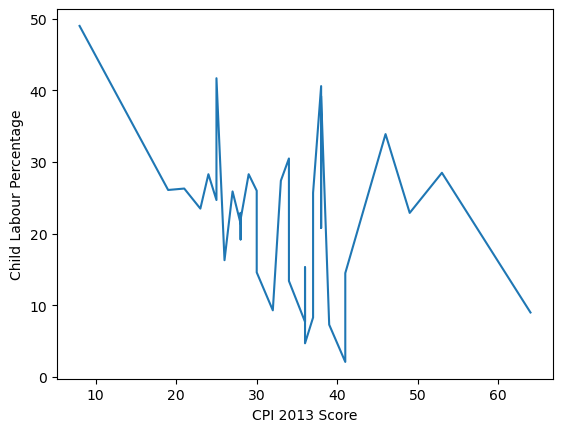

In [69]:
africa_cpi_cl=africa_cpi_cl.compute([('Africa Child Labour Rank', agate.Rank('Total (%)',reverse = True)),])
africa_cpi_cl=africa_cpi_cl.compute([('Africa CPI Rank', agate.Rank('CPI 2013 Score')),])
cl_mean=africa_cpi_cl.aggregate(agate.Mean('Total (%)'))
cpi_mean=africa_cpi_cl.aggregate(agate.Mean('CPI 2013 Score'))

def highest_rates(row):
    if row['Total (%)']>cl_mean and row['CPI 2013 Score']<cpi_mean:
        return True
    return False

highest_cpi_cl=africa_cpi_cl.where(lambda x:highest_rates(x))

for r in highest_cpi_cl.rows:
    print("{}:{}%-{}".format(r['Country / Territory'],r['Total (%)'],r['CPI 2013 Score']))
    
plt.plot(africa_cpi_cl.columns['CPI 2013 Score'],africa_cpi_cl.columns['Total (%)'])
plt.xlabel('CPI 2013 Score')
plt.ylabel('Child Labour Percentage')
plt.show()